# Modelling and Evaluation

## Objective

* To answer business requirement 2:
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Saved model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file



---

# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set working directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspaces/Mildew_Detection_pjkt')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/Mildew_Detection_pjkt'

## Set input directories

**Set train, validation and test paths**

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Confirm the new current directory

In [6]:
current_dir = os.getcwd()
current_dir

'/workspaces/Mildew_Detection_pjkt'

## Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set Label names

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


## Set image shape

In [9]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

**Number of images in train, test and validation data**

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




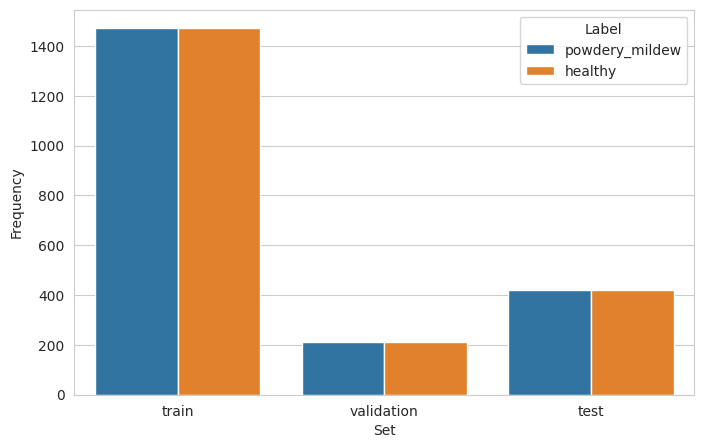

In [10]:
df_freq_list = []

for folder in ['train', 'validation', 'test']:
    for label in labels:
        folder_path = os.path.join(my_data_dir, folder, label)
        num_images = len(os.listdir(folder_path))

        df_freq_list.append({
            'Set': folder,
            'Label': label,
            'Frequency': num_images
        })

        print(f"* {folder} - {label}: {num_images} images")

df_freq = pd.DataFrame(df_freq_list)

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


---

# Image data augmentation

## Image Data Generator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Initialize Image Data Generator**

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

**Augment training image dataset**

In [13]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Augment validation image dataset**

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Augment test image dataset**

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Plot augmented training image**

(20, 256, 256, 3)


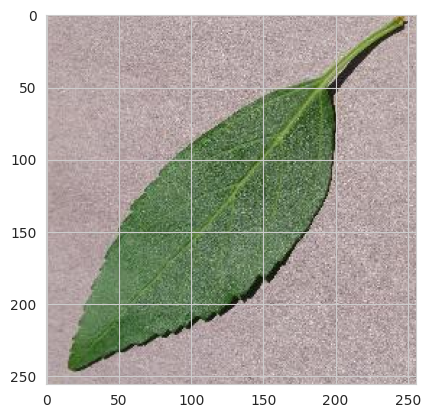

(20, 256, 256, 3)


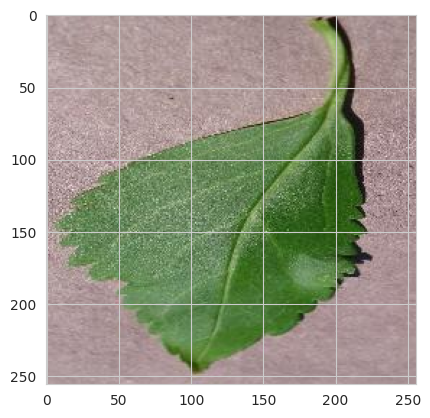

(20, 256, 256, 3)


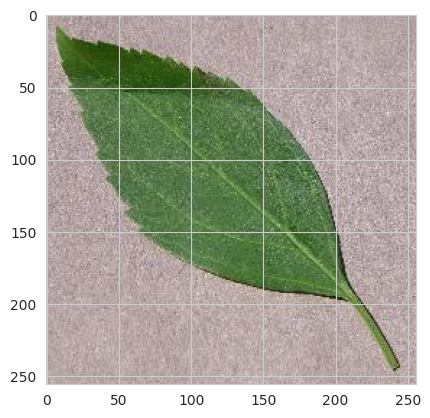

In [16]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


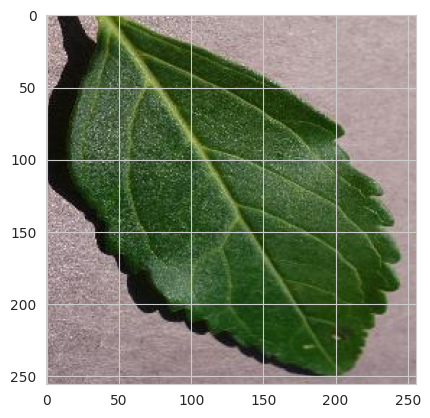

(20, 256, 256, 3)


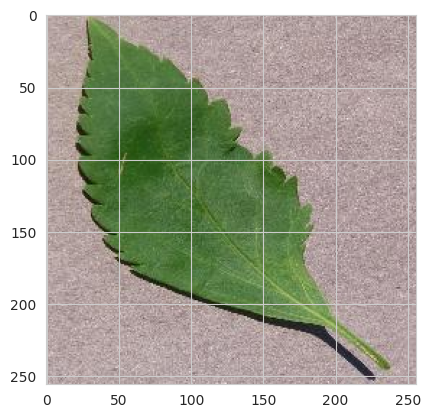

(20, 256, 256, 3)


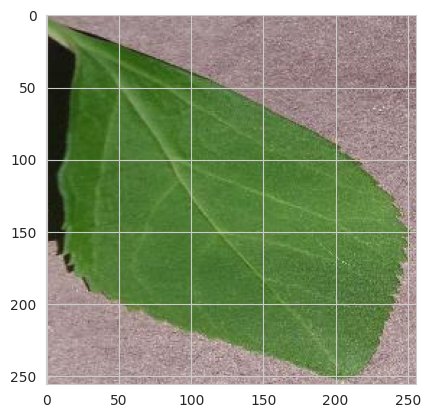

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

**Save class_indices**

In [18]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

----

# Model Creation

### ML model

**Import packages**

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

**Create model upon which the predictions for the final version will be based.**

In [20]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

### Model Summary

In [21]:
create_tf_model().summary()

2024-01-15 21:52:39.508447: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

**Early Stopping**

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

**Fit model for model training**

In [23]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-01-15 21:53:08.622897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 789s 5s/step - loss: 0.2461 - accuracy: 0.8796 - val_loss: 0.2081 - val_accuracy: 0.9595
Epoch 2/25
147/147 [==============================] - 687s 5s/step - loss: 0.0583 - accuracy: 0.9798 - val_loss: 0.1074 - val_accuracy: 0.9810
Epoch 3/25
147/147 [==============================] - 733s 5s/step - loss: 0.0435 - accuracy: 0.9863 - val_loss: 0.0866 - val_accuracy: 0.9905
Epoch 4/25
147/147 [==============================] - 813s 6s/step - loss: 0.0310 - accuracy: 0.9911 - val_loss: 0.0144 - val_accuracy: 0.9952
Epoch 5/25
147/147 [==============================] - 727s 5s/step - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.0180 - val_accuracy: 0.9952
Epoch 6/25
147/147 [==============================] - 655s 4s/step - loss: 0.0711 - accuracy: 0.9754 - val_loss: 0.0656 - val_accuracy: 0.9833
Epoch 00006: early stopping


**Load saved best model**

In [24]:
from keras.models import load_model

model.save('outputs/v1/powdery_mildew_model.h5')

# Model Perfomance

### Model learning curve

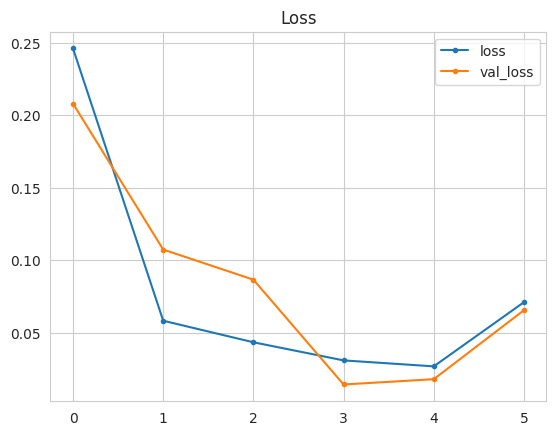

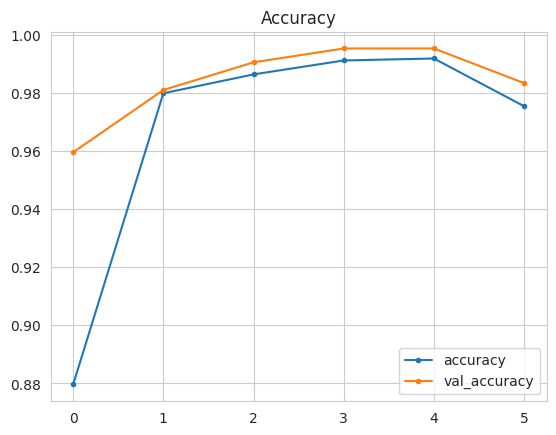

In [25]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

### Import packages

In [26]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

**Load saved model**

In [27]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_model.h5')

**Evaluate model on test set**

**The performance on the test set answers Business Requirement 2 and meets the project requirements with at least 87% accuracy on test set**

In [28]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

43/43 [==============================] - 49s 1s/step - loss: 0.0649 - accuracy: 0.9775
Model accuracy: 97.75%
Model Loss:  0.0648975521326065


**Save evaluation pickle**

In [29]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

**Load a random image as PIL**

Image shape: (256, 256), Image mode: RGB


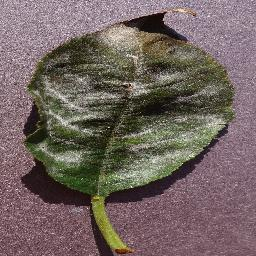

In [30]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select Uninfected or Parasitized

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

**Convert image to array and prepare for prediction**

In [31]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


**Predict class probabilities**

In [32]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9999474
powdery_mildew


---

# Push files to Repo

**Push generated/new files from this session to Github repo**

*  gitignore

In [33]:
!cat .gitignore


core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
inputs/cherryleaves_dataset/cherry-leaves/train
inputs/cherryleaves_dataset/cherry-leaves/test

In [34]:
!git status

Refresh index: 100% (12670/12670), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   app_pages/ml_performance_metrics_page.py
	modified:   jupyter_notebooks/.ipynb_checkpoints/ModellingEvaluation-checkpoint.ipynb
	modified:   jupyter_notebooks/ModellingEvaluation.ipynb
	modified:   outputs/v1/evaluation.pkl
	modified:   outputs/v1/model_training_acc.png
	modified:   outputs/v1/model_training_losses.png
	modified:   outputs/v1/powdery_mildew_model.h5

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	assets/

no changes added to commit (use "git add" and/or "git commit -a")


In [35]:
!git add .

In [36]:
!git commit -m "Add new files/plots after prediction"

[main 512c0be] Add new files/plots after prediction
 10 files changed, 88 insertions(+), 132 deletions(-)
 rewrite app_pages/ml_performance_metrics_page.py (76%)
 create mode 100644 assets/streamlit_app_images/Labels_frequencies.png
 create mode 100644 assets/streamlit_app_images/model_training _losses.png
 create mode 100644 assets/streamlit_app_images/model_training_accuracy.png
 rewrite outputs/v1/model_training_acc.png (99%)
 rewrite outputs/v1/model_training_losses.png (98%)


In [37]:
!git pull

Already up to date.


In [38]:
!git config --global pull.rebase true

In [39]:
!git push

Enumerating objects: 31, done.
Counting objects: 100% (30/30), done.
Delta compression using up to 4 threads
Compressing objects: 100% (16/16), done.
Writing objects: 100% (19/19), 68.93 MiB | 4.25 MiB/s, done.
Total 19 (delta 8), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (8/8), completed with 7 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/powdery_mildew_model.h5 is 85.07 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/Flora-King/Mildew_Detection_pjkt
   1464ff4..512c0be  main -> main


---